Project image sequence colorization 

LACHOUQUE Jacque 
KOÏTA Adama


In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
import os

In [5]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [6]:
def imshow_plt(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    
def imshow_cv(image, cmap=None):
  plt.imshow(image, cmap)
  plt.show()

In [11]:
myimage = io.imread("dataset/sketch/1.jpg")
#imshow_plt( [myimage], ['Image1'])
print(myimage.shape)

(557, 362, 3)


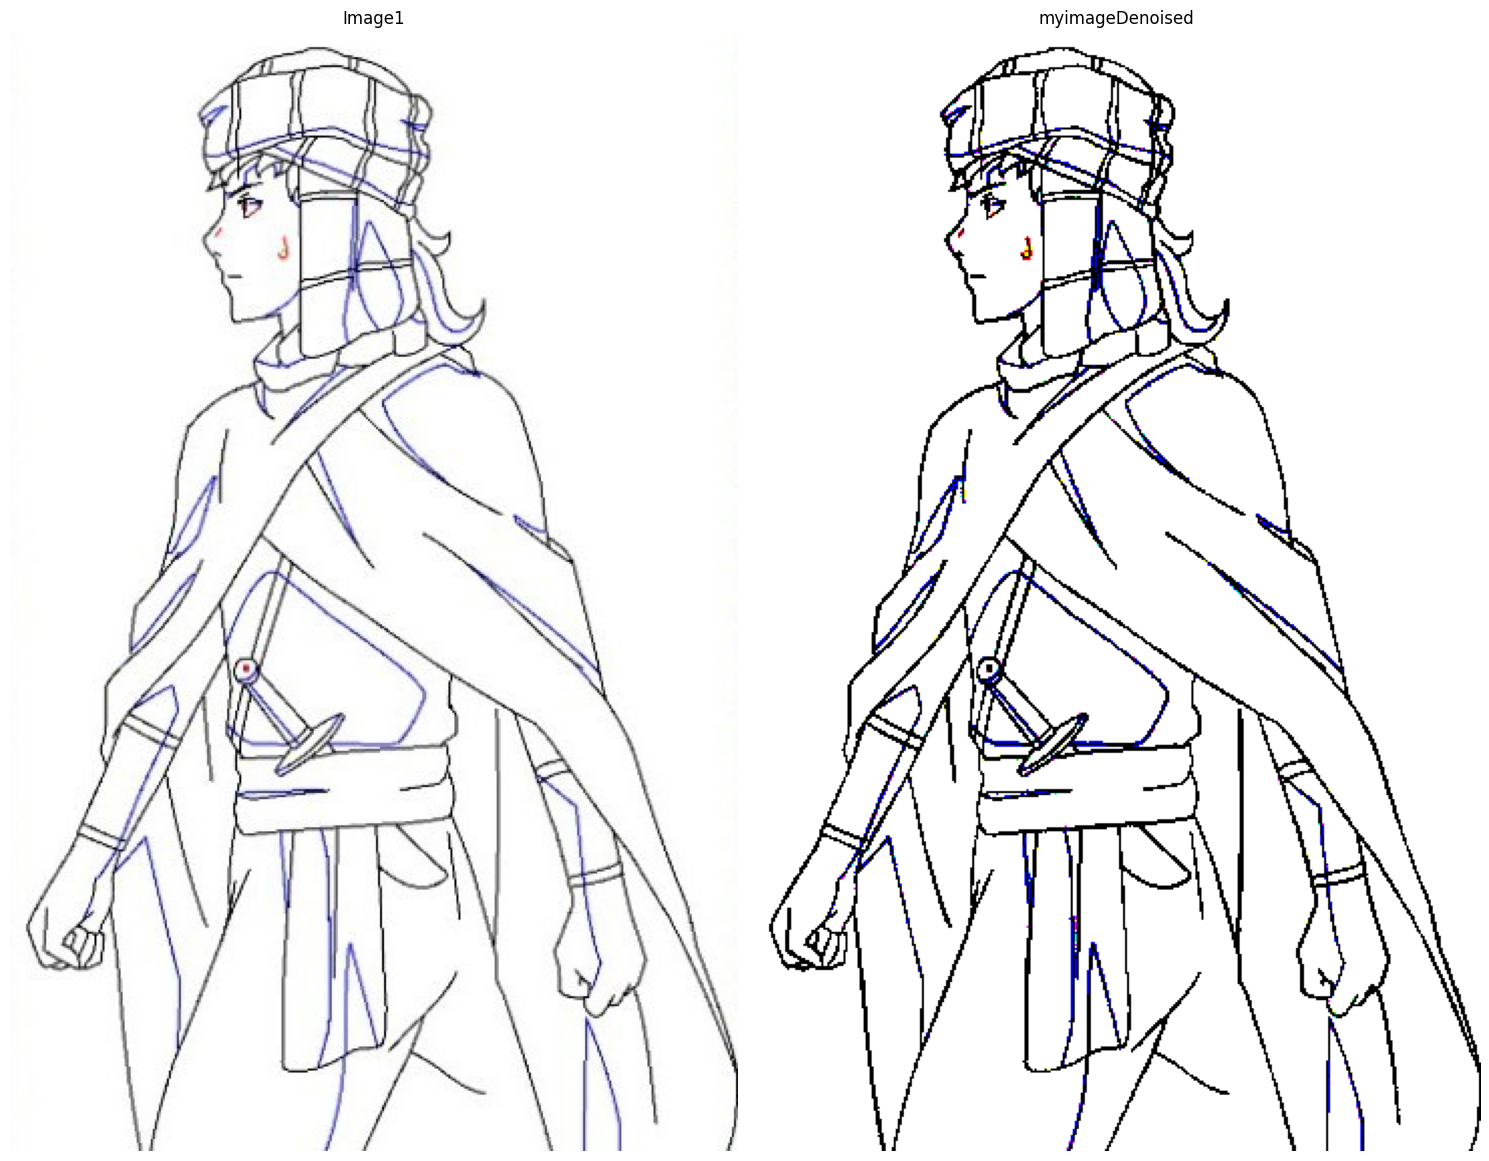

In [8]:
def threshold(img, value):
   """
   Delete noise and highligh the contours
   parameters:
      image : np.ndarray 
         image to denoise
      value : int
         treshold value of the pixel color
   returns:
      image denoised
   """
   return np.where(img <= value, 0, 255)



myimage_denoised = threshold(myimage,200)

imshow_plt( [myimage, myimage_denoised], ['Image1', 'myimageDenoised'])


In [9]:
def classes_matrix_to_image(classes_matrix, list_class):
    image = np.zeros((classes_matrix.shape[0],classes_matrix.shape[1],3), dtype=int)
    for c in list_class:
        mask = (classes_matrix == c)
        random_color = (randint(0, 255), randint(0, 255), randint(0, 255))
        image[mask] = random_color
        #print("class "+ str(c)+" color:",random_color)
    return image


def filling(i,j,classes_matrix,treated_pixels, class_num ):
    #private function
    stack = [(i,j)] #utilisation de stack car probleme avec la recursion

    while stack :
        x,y = stack.pop()
        if(classes_matrix[x][y] == 0):
            classes_matrix[x][y] = class_num
            treated_pixels[x][y] = True
            if(x != 0):
                #classes_matrix = filling(x-1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x - 1, y))
            if(x != classes_matrix.shape[0]-1):
                #classes_matrix =filling(x+1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x + 1, y))
            if(y != 0):
                #classes_matrix =filling(x,y-1,classes_matrix,treated_pixels, class_num)
                stack.append((x, y - 1))
            if(y != classes_matrix.shape[1]-1):
                #classes_matrix =filling(x,y+1,classes_matrix,treated_pixels, class_num)
                stack.append((x , y+ 1))
    return classes_matrix



def assign_class_to_pixel_by_filling(image):


    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
   
    print(classes_matrix.shape)
    #imshow_cv(classes_matrix)
    
    last_class = 1
    classes_num_list = [1]
    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)

    mask_contour = (classes_matrix == -1) # -1 is the value of contours 
    treated_pixels[mask_contour] = True        
    while(np.isin(classes_matrix,0).any()):
        #classes_matrix, new_treated_pixels = apply_class_in_matrix(classes_matrix, treated_pixels,last_class)
        #treated_pixels = new_treated_pixels.copy()
        fill = False
        for line in range(classes_matrix.shape[0]):
            for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
                if(classes_matrix[line][col] == 0):
                    filling(line, col,classes_matrix, treated_pixels,last_class)
                    fill =True

                    break
            if(fill): break  
        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list


In [10]:

print("filling with denoised image")
classes_matrix_image_denoised, classes_num_list_image_denoised = assign_class_to_pixel_by_filling(myimage_denoised)
imshow_cv(classes_matrix_to_image(classes_matrix_image_denoised, classes_num_list_image_denoised))

filling with denoised image
(557, 362)


NameError: name 'randint' is not defined

(526, 478, 4)


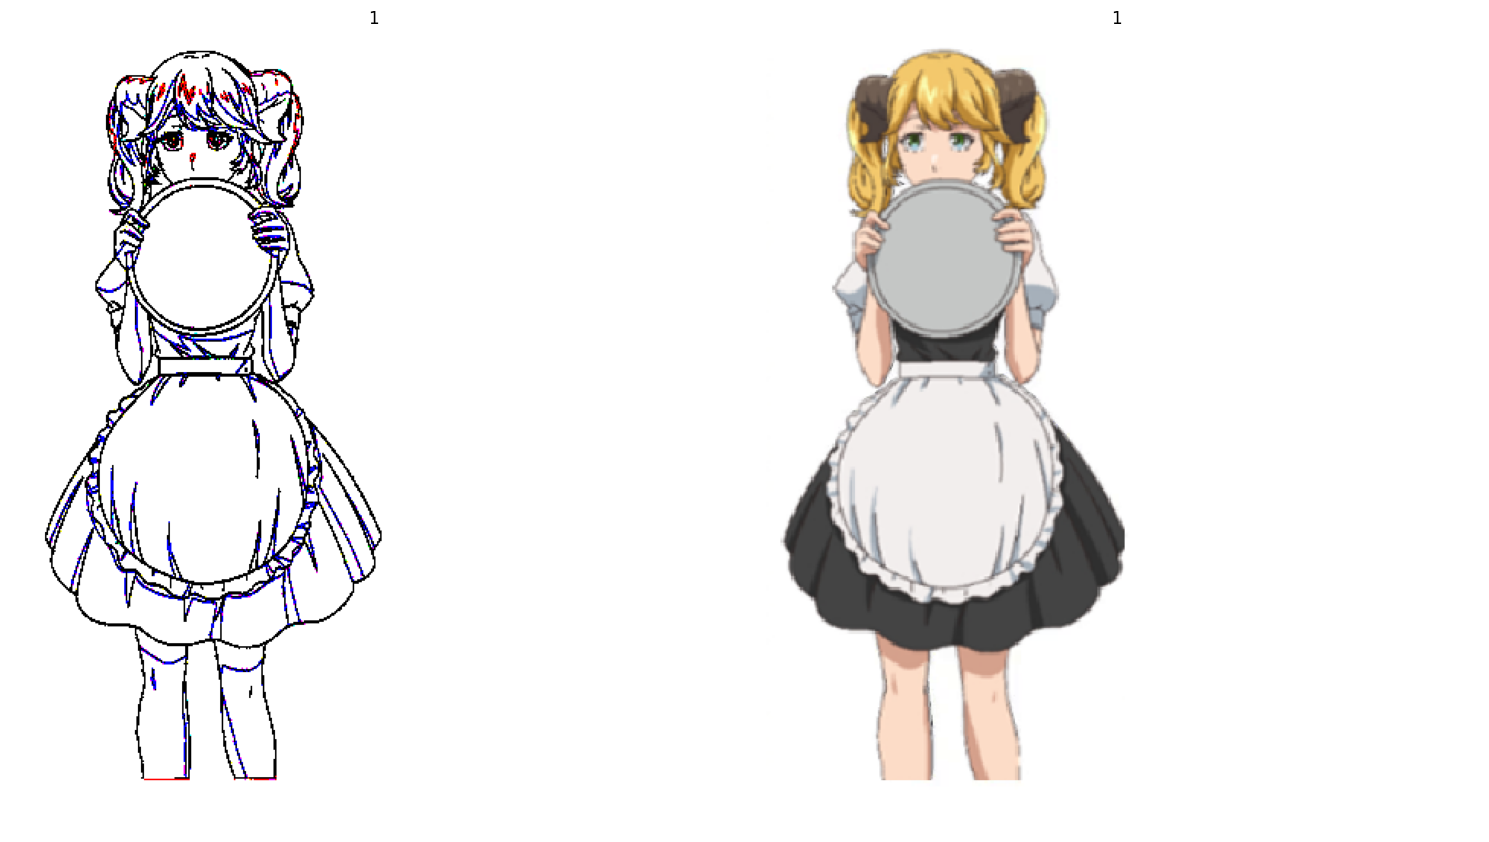

In [ ]:
image_references = [ io.imread("dataset/colored/sequence1/1.png"),220]
images = [threshold(io.imread("dataset/sketch/sequence1/1.png"),220), (io.imread("dataset/colored/sequence1/1.png"))]

imshow_plt( images, ['1', '1'])
print(images[0].shape)



(526, 478)
Apply pixel from previous to new


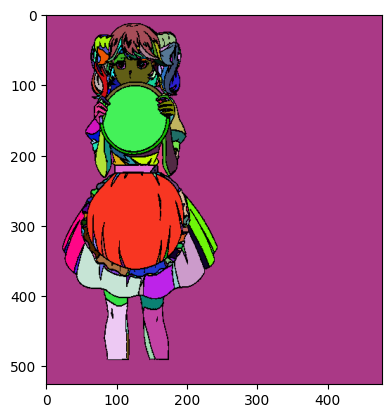

In [ ]:
#color first image 
classes_matrix , classes_num_list = assign_class_to_pixel_by_filling(images[0])
image_colored = classes_matrix_to_image(classes_matrix, classes_num_list)
print('Apply pixel from previous to new')
imshow_cv(image_colored)

In [ ]:

from collections import Counter

def assign_color_to_class_from_reference(image_classes, list_classes, image_reference):
    """ 
    This class allows to assign a color to each image class from the reference image
    parameters:
        -image_classes : np.ndarray 
            matrix of the classes associated to each pixel
        - list_classes : list 
            list of classes values
        image_reference : np.ndarray
            colored image reference
    """
    output_image = np.zeros((*image_classes.shape, 3), dtype=int)

    for c in list_classes:
        mask = (image_classes == c)
        indices = np.argwhere(mask)

        if len(indices) > 0:
            colors = [tuple(image_reference[i, j]) for i, j in indices]
            most_common_color = Counter(colors).most_common(1)[0][0]

            # Assigner la couleur trouvée à tous les pixels de la classe
            output_image[mask] = (most_common_color[0], most_common_color[1],most_common_color[2])

    return output_image

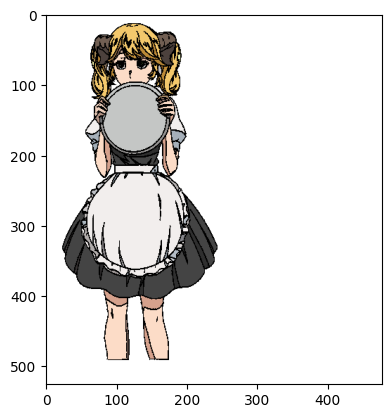

In [ ]:
image_color_from_sketch = assign_color_to_class_from_reference(classes_matrix,classes_num_list, image_references[0])
imshow_cv(image_color_from_sketch)
